# Установка зависимостей

In [13]:
import re
import os
from google.colab import drive, files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from xgboost import XGBRegressor, XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder, PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import seaborn as sns

from lightgbm import LGBMClassifier

import gc
import warnings

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = "/content/drive/MyDrive/Study/7_semestr/ML/data.json"

# Графики

In [7]:
df = pd.read_json(path, orient ='records')
df

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [8]:
# Смотрим информацию о датасете, проверяем все ли ячейки заполнены
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [9]:
# Смотрим какие колонки в датасете
cols = df.columns
cols

Index(['id', 'cuisine', 'ingredients'], dtype='object')

In [10]:
# Смотрим уникальные cuisine
df.cuisine.unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [ ]:
print('Maximum of ingredients in a dish: ', df['ingredients'].str.len().max())
print('Minimum of ingredients in a dish: ', df['ingredients'].str.len().min())

Maximum of ingredients in a dish:  65
Minimum of ingredients in a dish:  1


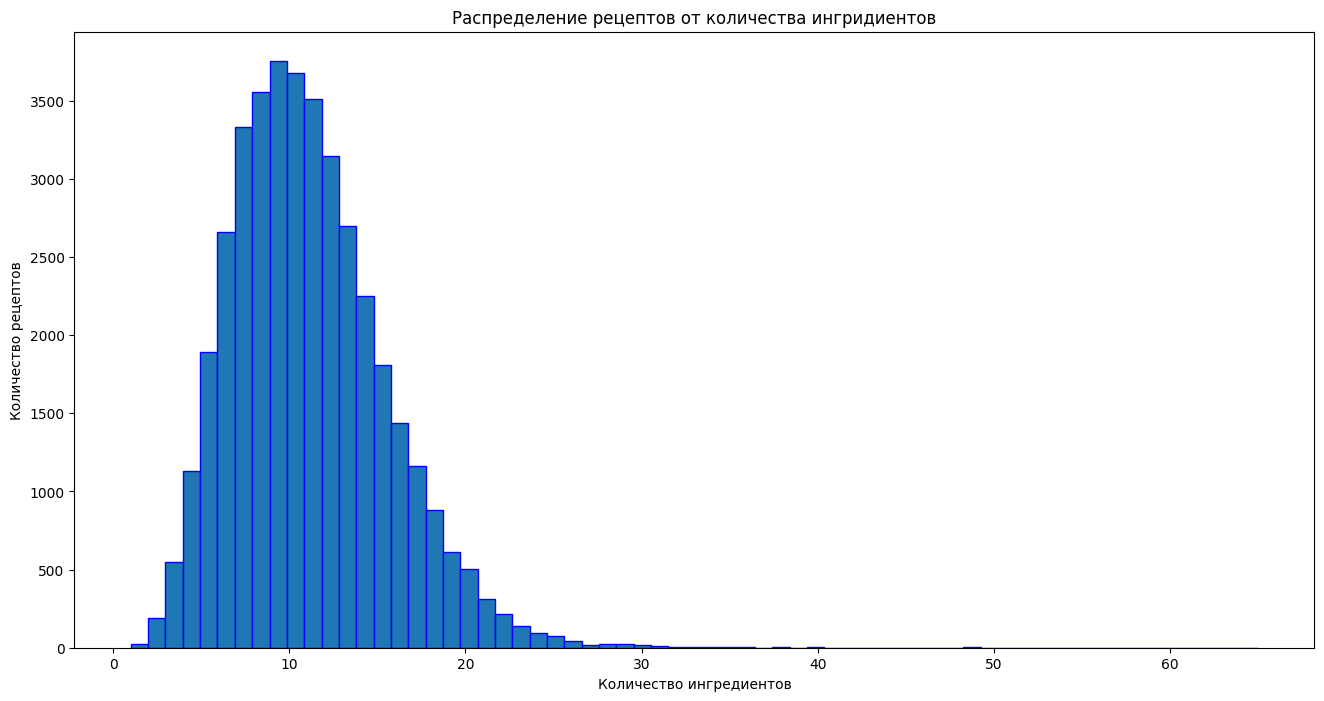

In [ ]:
plt.hist(df['ingredients'].str.len(),bins=max(df['ingredients'].str.len()),edgecolor='b')
plt.gcf().set_size_inches(16,8)
plt.title('Распределение рецептов от количества ингридиентов')
plt.xlabel('Количество ингредиентов')
plt.ylabel('Количество рецептов')
plt.show()

<Axes: >

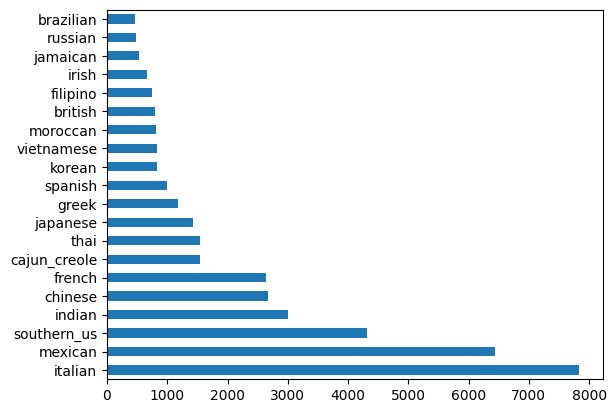

In [ ]:
# выведем распределение блюд для каждой из стран
df.cuisine.value_counts().plot.barh()

Видим, что классы плохо распределены, можно достичь accuracy = 20% просто говоря, что блюдо итальянское))

In [14]:
# Игнорирование предупреждений о производительности
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Преобразование списка ингредиентов в один список
massive_products = list(set(ingredient for sublist in df['ingredients'] for ingredient in sublist))

# Создание словаря для присвоения уникальных индексов ингредиентам
voc_products = {ingredient: i + 1 for i, ingredient in enumerate(massive_products)}

# Замена строк в столбце 'ingredients' на списки индексов
df['ingredients'] = df['ingredients'].apply(lambda x: [voc_products[ingredient] for ingredient in x])

# Создание отдельных столбцов для каждого ингредиента
for i, ingredient in tqdm(enumerate(massive_products), total=len(massive_products)):
    df[f'ingr_{i+1}'] = df['ingredients'].apply(lambda x: 1 if i+1 in x else 0)

# Восстановление вывода предупреждений (если нужно)
warnings.simplefilter(action='default', category=pd.errors.PerformanceWarning)

  0%|          | 0/6714 [00:00<?, ?it/s]

In [15]:
df.columns

Index(['id', 'cuisine', 'ingredients', 'ingr_1', 'ingr_2', 'ingr_3', 'ingr_4',
       'ingr_5', 'ingr_6', 'ingr_7',
       ...
       'ingr_6705', 'ingr_6706', 'ingr_6707', 'ingr_6708', 'ingr_6709',
       'ingr_6710', 'ingr_6711', 'ingr_6712', 'ingr_6713', 'ingr_6714'],
      dtype='object', length=6717)

<Axes: xlabel='cuisine', ylabel='numberofingredient'>

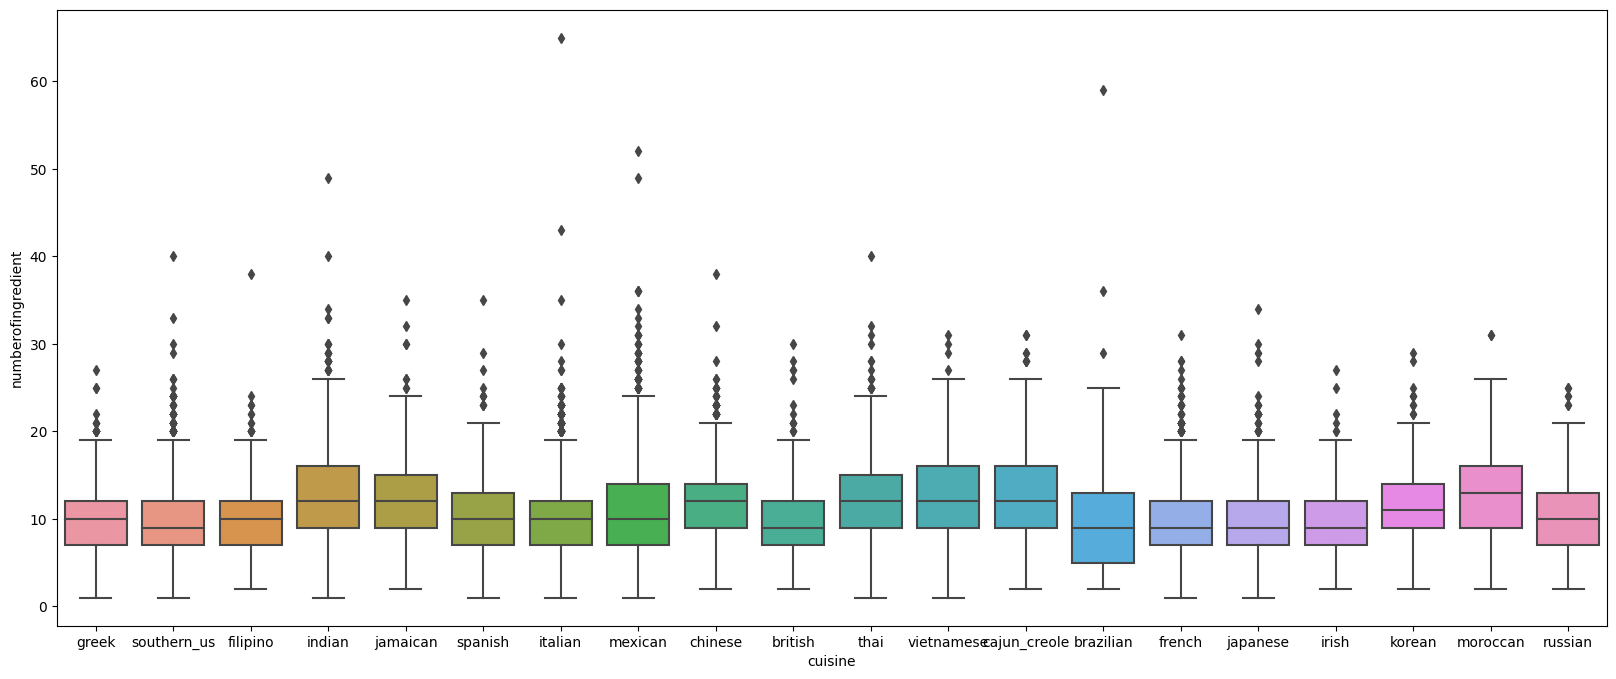

In [ ]:
#no of Ingredients
df['numberofingredient'] = df['ingredients'].str.len()
plt.figure(figsize=(20,8))
sns.boxplot(x='cuisine',y='numberofingredient',data=df)

# Обучение различных моделей

In [ ]:
X = df.drop(columns=['id', 'cuisine', 'ingredients']).values
y = df['cuisine'].values
# Освобождаем оперативку
del df
gc.collect()

0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = KNeighborsClassifier(n_neighbors=1000)
model.fit(X_train, y_train)
preds = model.predict(X_test)
del model
gc.collect()
accuracy = accuracy_score(y_test, preds)
print("Accuracy = ", accuracy)

Accuracy =  0.3801223497863069


In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
del model
gc.collect()
accuracy = accuracy_score(y_test, preds)
print("Accuracy = ", accuracy)

Accuracy =  0.7116399899438531


In [ ]:
model = LogisticRegression(penalty='l2', C = 100, max_iter=1000)
model.fit(X_train, y_train)
preds = model.predict(X_test)
del model
gc.collect()
accuracy = accuracy_score(y_test, preds)
print("Accuracy = ", accuracy)

Accuracy =  0.7145730327662784


## GridSearch RandomForest

In [ ]:
# написал свой гридсерч для RandomForest
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

for n_estimator in param_grid['n_estimators']:
    for depth in param_grid['max_depth']:
        for samples_split in param_grid['min_samples_split']:
            model = RandomForestClassifier(n_estimators=n_estimator,max_depth=depth,min_samples_split=samples_split)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            del model
            gc.collect()
            accuracy = accuracy_score(y_test, preds)
            print(f"RandomForest(n_estimators={n_estimator}, max_depth={depth}, min_samples_split={samples_split}): Accuracy = ", accuracy)

RandomForest(n_estimators=50, max_depth=None, min_samples_split=2): Accuracy =  0.7067795189809771
RandomForest(n_estimators=50, max_depth=None, min_samples_split=5): Accuracy =  0.7086231458979301
RandomForest(n_estimators=50, max_depth=10, min_samples_split=2): Accuracy =  0.4245369982401743
RandomForest(n_estimators=50, max_depth=10, min_samples_split=5): Accuracy =  0.42445319701667644
RandomForest(n_estimators=100, max_depth=None, min_samples_split=2): Accuracy =  0.7107181764853767
RandomForest(n_estimators=100, max_depth=None, min_samples_split=5): Accuracy =  0.7110533813793681
RandomForest(n_estimators=100, max_depth=10, min_samples_split=2): Accuracy =  0.4319953071314841
RandomForest(n_estimators=100, max_depth=10, min_samples_split=5): Accuracy =  0.43073828877901615


# Результаты

**Лучший результат:**

RandomForest(n_estimators=100, max_depth=None, min_samples_split=5): Accuracy =  0.7110533813793681
